In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import graph_overfit

import numpy as np
import pandas as pd
import dill as pkl
import os
import matplotlib.pyplot as plt
import tqdm

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

torch.manual_seed(seed=73)
np.random.seed(seed=73)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
X_train = np.load(os.path.join('data', 'X_train_transformed.npy'), allow_pickle=True)
y_train = np.load(os.path.join('data', 'y_train.pkl'), allow_pickle=True)
X_test = np.load(os.path.join('data', 'X_test_transformed.npy'), allow_pickle=True)
y_test = np.load(os.path.join('data', 'y_test.pkl'), allow_pickle=True)
X_val = np.load(os.path.join('data', 'X_val_transformed.npy'), allow_pickle=True)
y_val = np.load(os.path.join('data', 'y_val.pkl'), allow_pickle=True)
X_all = np.load(os.path.join('data', 'X_all_transformed.npy'), allow_pickle=True)
y_all = np.load(os.path.join('data', 'y_all.pkl'), allow_pickle=True)

"""
# Predict GEM-features

gem_classifiers = pkl.load(open(os.path.join('models', 'gem_classifiers.pkl'), 'rb'))

X_train_new = X_train.copy()
X_test_new = X_test.copy()
for clf in gem_classifiers.values():
    scaler = StandardScaler()
    X_train_new = np.c_[X_train_new, scaler.fit_transform(clf.predict(X_train))]
    X_test_new = np.c_[X_test_new, scaler.fit_transform(clf.predict(X_test))]

X_train = X_train_new
X_test = X_test_new
"""

X_folds = np.load(os.path.join('data', 'X_folds_tuple.npy'), allow_pickle=True)
y_folds = np.load(os.path.join('data', 'y_folds_tuple.npy'), allow_pickle=True)
fold_ids = [(np.array(fold.index)) for fold in X_folds]

X_tensor = torch.tensor(X_train.astype(np.float32))
y_train -= 1
y_tensor = torch.tensor(y_train.values).type(torch.LongTensor)

train_data = TensorDataset(X_tensor, y_tensor)

X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test -= 1
y_test_tensor = torch.tensor(y_test.values).type(torch.LongTensor)

test_data = TensorDataset(X_test_tensor, y_test_tensor)

X_val_tensor = torch.tensor(X_val.astype(np.float32))
y_val -= 1
y_val_tensor = torch.tensor(y_val.values).type(torch.LongTensor)

val_data = TensorDataset(X_val_tensor, y_val_tensor)

X_all_tensor = torch.tensor(X_all.astype(np.float32))
y_all -= 1
y_all_tensor = torch.tensor(y_all.values).type(torch.LongTensor)

all_data = TensorDataset(X_all_tensor, y_all_tensor)



train_loader = DataLoader(train_data,
                        shuffle=True,
                        batch_size=64,
                        num_workers=0)

test_loader = DataLoader(test_data,
                        shuffle=True,
                        batch_size=32,
                        num_workers=0)

val_loader = DataLoader(val_data,
                        shuffle=True,
                        batch_size=32,
                        num_workers=0)

all_loader = DataLoader(all_data,
                        shuffle=True,
                        batch_size=32,
                        num_workers=0)

In [ ]:
X_train.shape

(1597, 99)

In [ ]:
def custom_cv_folds(fold_ids):
    fold_ids = np.array(fold_ids, dtype=object)
    for n in range(len(fold_ids)):
        all_ids = list(range(len(fold_ids)))
        all_ids.remove(n)
        yield np.concatenate(fold_ids[all_ids]), fold_ids[n]

In [ ]:
def plot_training(train_vals, test_vals, base_vals, plot_baseline=True, single=False):
    fig, axs = plt.subplots(3,1, figsize=(10, 15))
    titles = ['Loss', 'Accuracy', 'Revenue']
    for n, (title, train, test, base) in enumerate(zip(titles, train_vals, test_vals, base_vals)):

        if title == 'Loss':
            if single:
                train = (-1.) * np.array(train)
                test = (-1.) * np.array(test)
                base = (-1.) * np.array(base)
            axs[n].plot(np.array(train) / len(X_train), label='training set')
            axs[n].plot(np.array(test) / len(X_val), label='validation set')
            if plot_baseline:
                axs[n].plot(np.array(base) / len(X_val), label='baseline classifier')

        else:
            axs[n].plot(train, label='training set')
            axs[n].plot(test, label='validation set')
            if plot_baseline:
                axs[n].plot(base, label='baseline classifier')
        
        axs[n].set_title(title)
        axs[n].legend()

    plt.legend()
    plt.show()

    return fig

In [ ]:
def calculate_revenue(predictions, targets, cost_matrix= torch.tensor([
                                                        [5, -5, -5, 2],
                                                        [-5, 10, 2, -5],
                                                        [-5, 2, 10, -5],
                                                        [2, -5, -2, 5]
                                                        ], device=device), mode='train'):
    winners = predictions.argmax(dim=1)
    max_rev = 16705
    if mode == 'val':
        max_rev = 2625
    elif mode == 'test':
        max_rev = 3375
    return torch.sum(cost_matrix[targets, winners]) / max_rev

In [ ]:
class CostSensitiveRegularizedLoss(nn.Module):
    def __init__(self, cost_matrix, lambd, reduction='mean'):
        super(CostSensitiveRegularizedLoss, self).__init__()
        self.cost_matrix = (-1.)*cost_matrix
        self.base_loss = torch.nn.CrossEntropyLoss()
        self.lambd = lambd
        self.reduction = reduction
    
    def forward(self, outputs, labels):
        base_l = self.base_loss(outputs, labels)
        cost_l = (self.cost_matrix[labels]*outputs.float()).sum(dim=-1)
        if self.reduction == 'mean':
            total_l = base_l + self.lambd * cost_l.mean()
        elif self.reduction == 'sum':
            total_l = base_l + self.lambd * cost_l.sum()

        return total_l

In [ ]:
class CostLossSingle(nn.Module):
    """
    Loss function using only the value predicted as most likely --> resulting in integer revenue
    """
    def __init__(self, cost_matrix):
        super(CostLossSingle, self).__init__()
        self.cost_matrix = cost_matrix

    def forward(self, outputs, labels):
        indices = torch.argmax(outputs, dim=1)
        predictions = outputs.clone().detach()
        predictions -= outputs
        predictions[:, indices] += 1
        loss = torch.sum((predictions * self.cost_matrix[labels]))

        return loss

In [ ]:
class CostLoss(nn.Module):
    """
    Loss function using probability of guessing every class (4x1 tensor with probabilities that sum to 1 and are
    corresponding to the classes) multiplied with row of the matrix corresponding to the correct label --> resulting in
    floating revenue
    """
    def __init__(self, cost_matrix):
        super(CostLoss, self).__init__()
        self.cost_matrix = (-1.)*cost_matrix

    def forward(self, outputs, labels):
        loss = torch.sum((outputs * self.cost_matrix[labels]))

        return loss


In [ ]:
class nn_classifier(nn.Module):
    def __init__(self, n_features=99):
        super(nn_classifier, self).__init__()

        self.input_layer = nn.Linear(n_features, 128)
        self.input_activation = nn.SELU()

        self.hidden_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.AlphaDropout(p=0.3),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.AlphaDropout(p=0.3),
            nn.Linear(32, 4)
        )

        self.output_layer = nn.Softmax(1)

    def forward(self, x):
        x = self.input_activation(self.input_layer(x))
        x = self.hidden_layers(x)
        output = self.output_layer(x)
        return output

In [ ]:
class nn_classifier2(nn.Module):
    def __init__(self, n_features=99):
        super(nn_classifier2, self).__init__()

        self.input_layer = nn.Linear(n_features, 256)
        self.input_activation = nn.SELU()

        self.hidden_layers = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.AlphaDropout(p=0.3),
            nn.SELU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.AlphaDropout(p=0.3),
            nn.SELU(),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.AlphaDropout(p=0.3),
            nn.SELU(),

            nn.Linear(32, 4)
        )

        self.output_layer = nn.Softmax(1)

    def forward(self, x):
        x = self.input_activation(self.input_layer(x))
        x = self.hidden_layers(x)
        output = self.output_layer(x)
        return output

In [ ]:
class nn_classifier3(nn.Module):
    def __init__(self, n_features, n_layers,hidden_size,dropout_rate):
        super(nn_classifier3, self).__init__()

        self.net = nn.Sequential()
        self.net.add_module('in_lin', nn.Linear(n_features, hidden_size))
        self.net.add_module('in_norm',  nn.BatchNorm1d(hidden_size))
        self.net.add_module('in_act', nn.ReLU())
        self.net.add_module('in_drop',nn.Dropout(dropout_rate))

        for i in range(n_layers):
            self.net.add_module(f'hidden_lin_{i}', nn.Linear(hidden_size, hidden_size))
            self.net.add_module(f'hidden_norm_{i}',  nn.BatchNorm1d(hidden_size))
            self.net.add_module(f'hidden_act_{i}', nn.ReLU())
            self.net.add_module(f'hidden_drop_{i}',nn.Dropout(dropout_rate))

        self.net.add_module('out_lin', nn.Linear(hidden_size, 4))
        self.net.add_module('out_norm',  nn.Softmax(1))

    def forward(self, x):
        return self.net(x)

In [ ]:
class BaselineClassifier(nn.Module):
    def __init__(self, y):
        super(BaselineClassifier, self).__init__()
        self.prediction = torch.mode(y)[0]

    def forward(self, x):
        output = torch.zeros((len(x), 4))
        output[:, self.prediction] = 1.
        return output

In [ ]:
def train(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer, loss_function: nn.modules.loss, device: torch.device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    revenue = 0

    for data in data_loader:
        inp, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(inp)

        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss

        winners = output.argmax(dim=1)
        correct += torch.sum((winners == target))
        total += len(target)
        revenue += calculate_revenue(output, target)

    #out_loss = running_loss / len(data_loader)

    accuracy = correct.float() / float(total)
    out_loss = running_loss

    return out_loss , accuracy, revenue


def evaluate(model: nn.Module, data_loader: DataLoader, loss_function: nn.modules.loss, device: torch.device, mode='val'):
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        revenue = 0

        for data in data_loader:
            inp, target = data[0].to(device), data[1].to(device)
            output = model(inp)
            loss = loss_function(output, target)

            running_loss += loss

            winners = output.argmax(dim=1)
            correct += torch.sum((winners == target))
            total += len(target)
            revenue += calculate_revenue(output, target, mode=mode)

        #out_loss = running_loss/len(data_loader)
        accuracy = correct.float() / float(total)
        out_loss = running_loss

    return out_loss , accuracy, revenue

In [ ]:
"""
cost_matrix_np = np.array([
    [5, -5, -5, 2],
    [-5, 10, 2, -5],
    [-5, 2, 10, -5],
    [2, -5, -2, 5]
    ])

cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], device=device)

scaler = MinMaxScaler()
cost_matrix_transformed = torch.Tensor(scaler.fit_transform(cost_matrix_np))
#cost_matrix_transformed = torch.nn.functional.normalize(torch.Tensor(cost_matrix))
"""

'\ncost_matrix_np = np.array([\n    [5, -5, -5, 2],\n    [-5, 10, 2, -5],\n    [-5, 2, 10, -5],\n    [2, -5, -2, 5]\n    ])\n\ncost_matrix = torch.tensor([\n        [5, -5, -5, 2],\n        [-5, 10, 2, -5],\n        [-5, 2, 10, -5],\n        [2, -5, -2, 5]\n        ], device=device)\n\nscaler = MinMaxScaler()\ncost_matrix_transformed = torch.Tensor(scaler.fit_transform(cost_matrix_np))\n#cost_matrix_transformed = torch.nn.functional.normalize(torch.Tensor(cost_matrix))\n'

In [ ]:
best_val_rev = 2350
best_val_loss = -730
for n in range(10000):
    #model = nn_classifier2()
    model = torch.load('models/best_model_loss_2.pt')
    print(f'\nRESTART...({n}/10000)\n################################ Current Best: {best_val_rev}, {best_val_loss} ################################\n')
    baseline_clf = BaselineClassifier(y_tensor)
    #model.to(device=device)

    cost_matrix = torch.tensor([
            [5, -5, -5, 2],
            [-5, 10, 2, -5],
            [-5, 2, 10, -5],
            [2, -5, -2, 5]
            ], dtype=torch.float, device=device)

    #loss_function = CostLoss(cost_matrix)
    loss_function = CostSensitiveRegularizedLoss(cost_matrix, 10)  # (-1.)*
    #loss_function = nn.CrossEntropyLoss()
    lr = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-8, factor=0.1, patience=2)

    epochs = 1000
    train_losses, train_accs, train_revs = [], [], []
    test_losses, test_accs, test_revs = [], [], []
    base_losses, base_accs, base_revs = [], [], []

    for update in range(epochs):
        train_loss, train_acc, train_rev = train(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss.detach())
        train_accs.append(train_acc.detach())
        train_revs.append(train_rev.detach())

        test_loss, test_acc, test_rev = evaluate(model, test_loader, loss_function, device)
        test_losses.append(test_loss.detach())
        test_accs.append(test_acc.detach())
        test_revs.append(test_rev.detach())

        scheduler.step(test_loss)

        baseline_loss, baseline_acc, baseline_rev = evaluate(baseline_clf, test_loader, loss_function, device)
        base_losses.append(baseline_loss)
        base_accs.append(baseline_acc)
        base_revs.append(baseline_rev)

        if update % 50 == 0:
            print(f'--------------- Epoch:{update} ---------------')
            print(f'Training Loss: {train_loss:.2f}\tTraining accuracy: {train_acc:.2f}\tTraining Revenue: {train_rev:.2f}')
            print(f'Val Loss: {test_loss:.2f}\tVal accuracy: {test_acc:.2f}\tVal Revenue: {test_rev:.2f}')

        """
        if test_rev > best_val_rev:
            best_val_rev = test_rev
            print(f'\n############### New Best: {float(test_rev)} ################\n')
            torch.save(model, os.path.join('models', 'best_model.pt'))
        
        if test_rev < 0.85*best_val_rev:
            break
        """

        if abs(test_loss) > abs(best_val_loss) or test_rev > best_val_rev:
            if abs(test_loss) > abs(best_val_loss):
                best_val_loss = test_loss
            else:
                best_val_rev = test_rev
            print(f'\n############### New Best: {float(test_rev)}, {float(test_loss)} ################\n')
            torch.save(model, os.path.join('models', 'best_model_loss_2.pt'))
        
        if abs(test_loss) < 0.9*abs(best_val_loss) or test_rev < 0.85*best_val_rev:
            print(f'Ended in Epoch {update}')
            break
        
    #plot_training((train_losses, train_accs, train_revs), (test_losses, test_accs, test_revs), (base_losses, base_accs, base_revs))

In [ ]:
torch.save(model, os.path.join('models', 'final_model.pt'))

In [ ]:
torch.save(model, 'models/test_rev_088.pt')

In [ ]:
cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], dtype=torch.float, device=device)

--------------- Epoch:0 ---------------
Training Loss: -1475.82	Training accuracy: 0.34	Training Revenue: 0.22
Val Loss: -392.85	Val accuracy: 0.42	Val Revenue: 0.34
--------------- Epoch:50 ---------------
Training Loss: -10948.54	Training accuracy: 0.68	Training Revenue: 0.68
Val Loss: -1738.08	Val accuracy: 0.68	Val Revenue: 0.68
--------------- Epoch:100 ---------------
Training Loss: -12610.04	Training accuracy: 0.76	Training Revenue: 0.78
Val Loss: -2025.34	Val accuracy: 0.78	Val Revenue: 0.79
--------------- Epoch:150 ---------------
Training Loss: -13369.67	Training accuracy: 0.79	Training Revenue: 0.81
Val Loss: -2189.81	Val accuracy: 0.82	Val Revenue: 0.84
--------------- Epoch:200 ---------------
Training Loss: -13861.51	Training accuracy: 0.82	Training Revenue: 0.84
Val Loss: -2275.11	Val accuracy: 0.85	Val Revenue: 0.88
--------------- Epoch:250 ---------------
Training Loss: -14328.30	Training accuracy: 0.85	Training Revenue: 0.87
Val Loss: -2348.45	Val accuracy: 0.89	Val

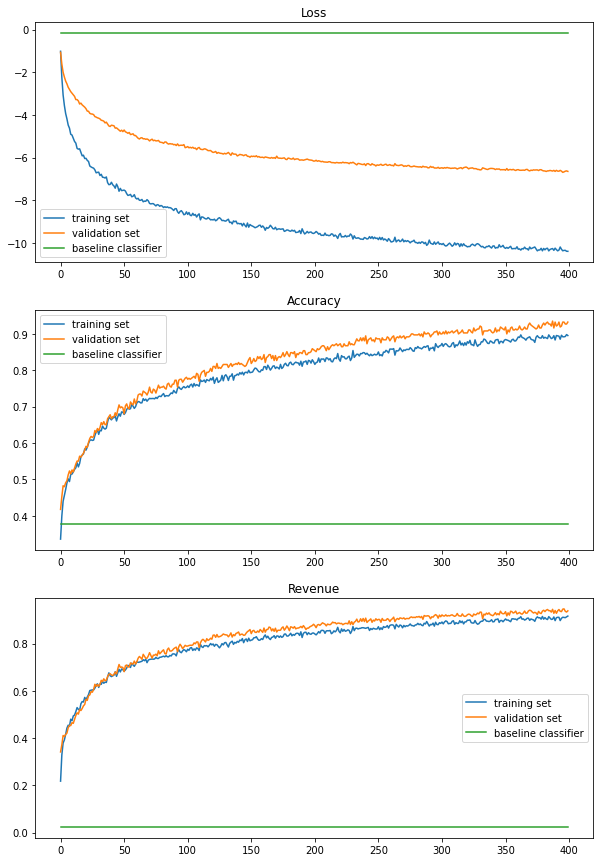

In [ ]:
model = nn_classifier3(99,dropout_rate=0.2,hidden_size=192,n_layers=1)
#model = torch.load('models/best_model_loss_2.pt')
#print(f'\nRESTART...({n}/10000)\n################################ Current Best: {best_val_rev}, {best_val_loss} ################################\n')
baseline_clf = BaselineClassifier(y_tensor)
#model.to(device=device)

cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], dtype=torch.float, device=device)

loss_function = CostLoss(cost_matrix)
#loss_function = CostSensitiveRegularizedLoss(cost_matrix, 10)  # (-1.)*
#loss_function = nn.CrossEntropyLoss()
#loss_function = CostLossSingle(cost_matrix)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-8, factor=0.1, patience=2)

epochs = 400
train_losses, train_accs, train_revs = [], [], []
test_losses, test_accs, test_revs = [], [], []
base_losses, base_accs, base_revs = [], [], []

for update in range(epochs):
    train_loss, train_acc, train_rev = train(model, all_loader, optimizer, loss_function, device)
    train_losses.append(train_loss.detach())

    train_accs.append(train_acc.detach())
    train_revs.append(train_rev.detach())

    test_loss, test_acc, test_rev = evaluate(model, val_loader, loss_function, device)
    test_losses.append(test_loss.detach())
    test_accs.append(test_acc.detach())
    test_revs.append(test_rev.detach())

    #scheduler.step(test_loss)

    baseline_loss, baseline_acc, baseline_rev = evaluate(baseline_clf, val_loader, loss_function, device)
    base_losses.append(baseline_loss)
    base_accs.append(baseline_acc)
    base_revs.append(baseline_rev)

    if update % 50 == 0:
        print(f'--------------- Epoch:{update} ---------------')
        print(f'Training Loss: {train_loss:.2f}\tTraining accuracy: {train_acc:.2f}\tTraining Revenue: {train_rev:.2f}')
        print(f'Val Loss: {test_loss:.2f}\tVal accuracy: {test_acc:.2f}\tVal Revenue: {test_rev:.2f}')

fin_loss, fin_acc, fin_rev = evaluate(model, test_loader, loss_function, device, mode='test')
print('------------------------ Score on Test Set ------------------------')
print(f'Test Loss: {fin_loss:.2f}\tTest accuracy: {fin_acc:.2f}\tTest Revenue: {train_rev:.2f}')

fig = plot_training((train_losses, train_accs, train_revs), (test_losses, test_accs, test_revs), (base_losses, base_accs, base_revs))

--------------- Epoch:0 ---------------
Training Loss: 32.05	Training accuracy: 0.25	Training Revenue: 0.01
Val Loss: 16.68	Val accuracy: 0.24	Val Revenue: -0.00
--------------- Epoch:50 ---------------
Training Loss: 29.10	Training accuracy: 0.49	Training Revenue: 0.22
Val Loss: 15.24	Val accuracy: 0.52	Val Revenue: 0.38
--------------- Epoch:100 ---------------
Training Loss: 28.03	Training accuracy: 0.54	Training Revenue: 0.25
Val Loss: 14.63	Val accuracy: 0.54	Val Revenue: 0.42
--------------- Epoch:150 ---------------
Training Loss: 27.06	Training accuracy: 0.60	Training Revenue: 0.31
Val Loss: 14.44	Val accuracy: 0.55	Val Revenue: 0.43
--------------- Epoch:200 ---------------
Training Loss: 26.35	Training accuracy: 0.63	Training Revenue: 0.34
Val Loss: 14.30	Val accuracy: 0.56	Val Revenue: 0.44
--------------- Epoch:250 ---------------
Training Loss: 26.03	Training accuracy: 0.64	Training Revenue: 0.36
Val Loss: 14.25	Val accuracy: 0.55	Val Revenue: 0.43
--------------- Epoch:30

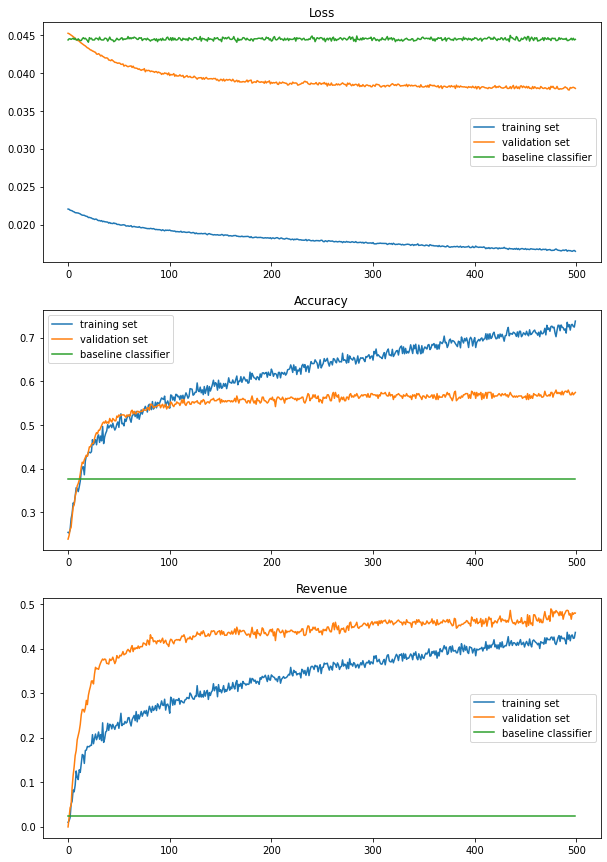

In [ ]:
model = nn_classifier3(99,dropout_rate=0.2,hidden_size=192,n_layers=1)
#model = torch.load('models/best_model_loss_2.pt')
#print(f'\nRESTART...({n}/10000)\n################################ Current Best: {best_val_rev}, {best_val_loss} ################################\n')
baseline_clf = BaselineClassifier(y_tensor)
#model.to(device=device)

cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], dtype=torch.float, device=device)

#loss_function = CostLoss(cost_matrix)
#loss_function = CostSensitiveRegularizedLoss(cost_matrix, 50)  # (-1.)*
loss_function = nn.CrossEntropyLoss()
#loss_function = CostLossSingle(cost_matrix)
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-8, factor=0.1, patience=2)

epochs = 500
train_losses, train_accs, train_revs = [], [], []
test_losses, test_accs, test_revs = [], [], []
base_losses, base_accs, base_revs = [], [], []

for update in range(epochs):
    train_loss, train_acc, train_rev = train(model, train_loader, optimizer, loss_function, device)
    train_losses.append(train_loss.detach())

    train_accs.append(train_acc.detach())
    train_revs.append(train_rev.detach())

    test_loss, test_acc, test_rev = evaluate(model, val_loader, loss_function, device)
    test_losses.append(test_loss.detach())
    test_accs.append(test_acc.detach())
    test_revs.append(test_rev.detach())

    #scheduler.step(test_loss)

    baseline_loss, baseline_acc, baseline_rev = evaluate(baseline_clf, val_loader, loss_function, device)
    base_losses.append(baseline_loss)
    base_accs.append(baseline_acc)
    base_revs.append(baseline_rev)

    if update % 50 == 0:
        print(f'--------------- Epoch:{update} ---------------')
        print(f'Training Loss: {train_loss:.2f}\tTraining accuracy: {train_acc:.2f}\tTraining Revenue: {train_rev:.2f}')
        print(f'Val Loss: {test_loss:.2f}\tVal accuracy: {test_acc:.2f}\tVal Revenue: {test_rev:.2f}')

fin_loss, fin_acc, fin_rev = evaluate(model, test_loader, loss_function, device, mode='test')
print('------------------------ Score on Test Set ------------------------')
print(f'Test Loss: {fin_loss:.2f}\tTest accuracy: {fin_acc:.2f}\tTest Revenue: {train_rev:.2f}')

fig = plot_training((train_losses, train_accs, train_revs), (test_losses, test_accs, test_revs), (base_losses, base_accs, base_revs))

In [ ]:
fig.savefig(os.path.join('figures', 'crossentropyloss'))

In [ ]:
cur_rev = 0
for batch in all_loader:
    cur_rev += sum(cost_matrix[batch[1], batch[1]])
print(cur_rev)

tensor(16705.)


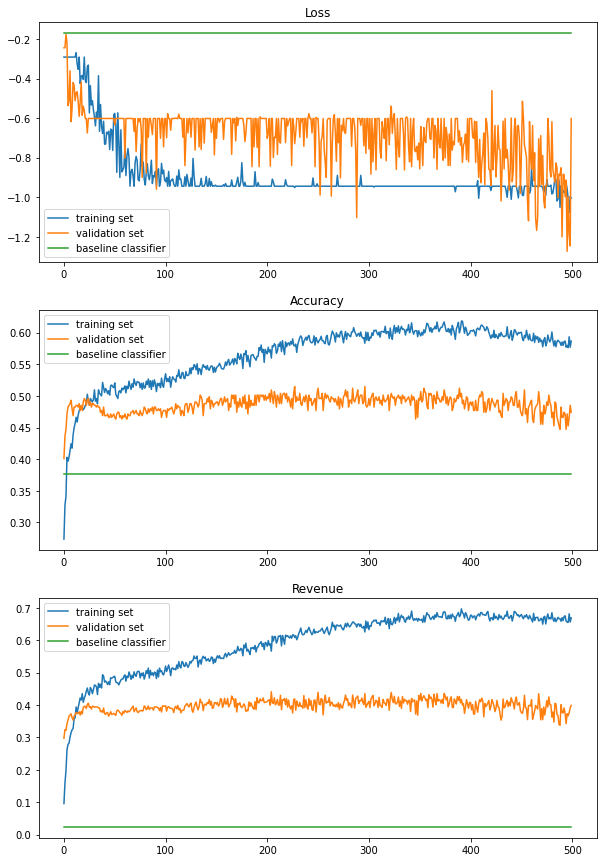

In [ ]:
'fig = plot_training((train_losses, train_accs, train_revs), (test_losses, test_accs, test_revs), (base_losses, base_accs, base_revs), single=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e2905743-bdaf-45dd-a896-9824e6125426' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>